# Pretrained neural network VGG16 with dense800-dense400 as a classifier

In [ ]:
# GPU info
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil as ps # library for retrieving information on running processes and system utilization
import humanize as hm # library for turning a number into a fuzzy human-readable
import os # library for operations with operation system 
import GPUtil as GPU # access to GPU subsystem
GPUs = GPU.getGPUs() # get number of GPUs
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = ps.Process(os.getpid())
print(f'Gen RAM Free: {hm.naturalsize( ps.virtual_memory().available )} | Proc size: {hm.naturalsize( process.memory_info().rss )}')
print( 'GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util: {2:3.0f}% | Total: {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print(f'GPU Model: {gpu.name}')

Gen RAM Free: 11.9 GB | Proc size: 95.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util:   0% | Total: 16280MB
GPU Model: Tesla P100-PCIE-16GB


In [1]:
# Keras's libraries
from tensorflow.keras.applications import VGG16 # Pretrained models
from tensorflow.keras.applications.vgg16 import preprocess_input # for preprocessing image for the model
from tensorflow.keras.models import Sequential # Sequentional model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization # Layers
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator # Load and augmentation
from tensorflow.keras.optimizers import Adam, Adadelta, SGD # Optimizers
from tensorflow.keras import utils # Utils for converting to One Hot-Encoding
from tensorflow.keras.preprocessing import image # Load images
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Callbacks

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Metrics

import numpy as np # Working with arrays
import matplotlib.pyplot as plt # For charts
from PIL import Image # Load images
import random # Random library
import math # Math functions
import os # File system utils
import gdown # Load files from web

# Draw charts in the same windows
%matplotlib inline

In [3]:
# Colab filesystem
from google.colab import files 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unpack files
!unzip -q -o '/content/drive/MyDrive/archive.zip' -d /content

In [5]:
# Look at the dirs
!ls /content/train

bag  bal  ban  bea  can  env  gbt  mon	pbt  toy


In [6]:
# Hyperparameters
TRAIN_PATH  = '/content/train'  # Our source files
TEST_PATH   = '/content/test'   # Here we will drop test set

TEST_SPLIT  = 0.2 # 20% for test data
VAL_SPLIT   = 0.2 # 20% for validation data 

IMG_WIDTH   = 224 # Image width for neural network
IMG_HEIGHT  = 224 # Image height for neural network

BATCH_SIZE    = 128                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
EPOCHS        = 100                       # Epochs

# Augmentation parameters
ROTATION_RANGE      = 8     # Degree range for random rotations
WIDTH_SHIFT_RANGE   = 0.2   # Horizontal shift limit up to %
HEIGHT_SHIFT_RANGE  = 0.2   # Vertical shift limit up to %
ZOOM_RANGE          = 0.15  # [1-zoom_range, 1+zoom_range]
BRIGHTNESS_RANGE    = (0.7, 1.3)  #  Range for picking a brightness shift value from
HORIZONTAL_FLIP     = True  # Randomly flip inputs horizontally

In [7]:
# A list of class names
CLASS_LIST = sorted(os.listdir(TRAIN_PATH)) # Assign number for each class by sorting the set of classes

# Number of classes
CLASS_COUNT = len(CLASS_LIST)

print(f'Labels: {CLASS_LIST}\nNumber of classes: {CLASS_COUNT}')

Labels: ['bag', 'bal', 'ban', 'bea', 'can', 'env', 'gbt', 'mon', 'pbt', 'toy']
Number of classes: 10


In [8]:
# Dividing the complete dataset into training and test sets
os.mkdir(TEST_PATH) # Folder for test data
total_count = 0
test_count = 0

for class_name in CLASS_LIST:
  class_path  = f'{TRAIN_PATH}/{class_name}'  # Full train dir path of the current class
  test_path   = f'{TEST_PATH}/{class_name}'   # Full test dir path for the current class
  class_files = os.listdir(class_path)        # A list of train images in the current class
  class_file_count = len(class_files)         # Total number of images in the current class folder
  os.mkdir(test_path)                         # Make a folder for the current test class images
  test_file_count = int(class_file_count*TEST_SPLIT) # The number of test data images from the current class
  random.shuffle(class_files)                 # Shuffle list of images in the current class
  test_files = class_files[:test_file_count]  # A list of test images in the current class
  for f in test_files:                        # Move test data images into new folder for test data for the current class
    os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
  total_count += class_file_count             # Increase counter for total images
  test_count += test_file_count               # Increase counter for test images
  print(f'Class: {class_name}, Total:{class_file_count}, Test data: {test_file_count}')

print(f'Total data: {total_count}, train data: {total_count-test_count}, test data: {test_count}')

Class: bag, Total:4939, Test data: 987
Class: bal, Total:8496, Test data: 1699
Class: ban, Total:2737, Test data: 547
Class: bea, Total:7719, Test data: 1543
Class: can, Total:9455, Test data: 1891
Class: env, Total:2093, Test data: 418
Class: gbt, Total:2817, Test data: 563
Class: mon, Total:8209, Test data: 1641
Class: pbt, Total:8225, Test data: 1645
Class: toy, Total:20102, Test data: 4020
Total data: 74792, train data: 59838, test data: 14954


In [ ]:
# Image Generators
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    validation_split=VAL_SPLIT,
    preprocessing_function=preprocess_input, # preprocess image
    )

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT,
    preprocessing_function=preprocess_input, # preprocess image
    )

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function=preprocess_input, # preprocess image
    )

In [ ]:
# Data generator for training
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
    )

# Data generator for validation
validation_generator = validation_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
    )

# Data generator for testing
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
    )

Found 55436 images belonging to 10 classes.
Found 13854 images belonging to 10 classes.
Found 5502 images belonging to 10 classes.


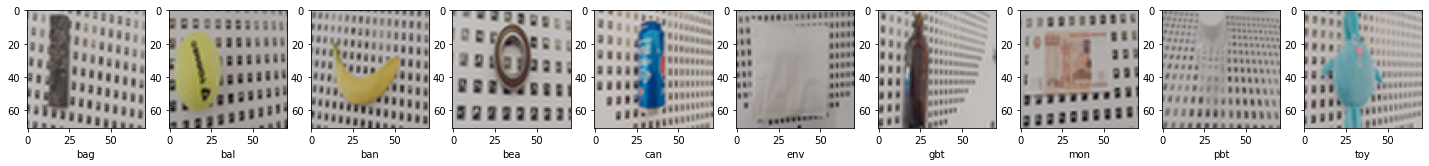

In [ ]:
# Look at the random images from each class
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))                   
for i in range(CLASS_COUNT):  # For each class
  class_path = TRAIN_PATH + '/' + CLASS_LIST[i]                                            
  images_list = os.listdir(class_path)
  image_path = class_path + '/' + random.choice(images_list)
  axs[i].imshow(image.load_img(image_path, target_size=(71, 71)))
  axs[i].set_xlabel(CLASS_LIST[i])
plt.show()

In [ ]:
# Callbacks
checkpoint = [
             ModelCheckpoint('/content/drive/MyDrive/2-VGG16-dense800-dense400.h5', 
             monitor='val_loss', 
             save_best_only=True)
             ]
early = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
lr_reduce = ReduceLROnPlateau(
                           monitor='val_loss',
                           patience=5, 
                           verbose=0, 
                           mode='auto'
                           )

In [ ]:
# Loading the pretrained model
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)
                  )

In [ ]:
# Freezing the weights of the pretrained neural network
vgg16_net.trainable = False

vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Creating a composite neural network based on the VGG16 model
model = Sequential()
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(800, activation='relu'))
model.add(Dense(400, activation='relu'))
# model.add(Dropout(0.1))  
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 800)               20071200  
                                                                 
 dense_1 (Dense)             (None, 400)               320400    
                                                                 
 dense_2 (Dense)             (None, 10)                4010      
                                                                 
Total params: 35,110,298
Trainable params: 20,395,610
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Function of training and evaluation
def train_model(model,
                train_data,
                val_data,
                test_data,
                class_labels=CLASS_LIST, 
                title='classifier'):
  
  # Model compilation
  model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

  # Model train
  history = model.fit(train_data,
                      steps_per_epoch = train_data.samples // BATCH_SIZE,
                      validation_data=val_data,
                      validation_steps = val_data.samples // BATCH_SIZE,
                      epochs=EPOCHS,
                      # batch_size=BATCH_SIZE,
                      callbacks=[early,checkpoint,lr_reduce])

  # Visualization of the training process
  plt.plot(history.history['accuracy'], label='Part of the right answers on the training set')
  plt.plot(history.history['val_accuracy'], label='Part of the right answers on the validation set')
  plt.xlabel('Epoch of the training')
  plt.ylabel('Part of the right answers')
  plt.legend()
  plt.show()

# Function for evaluating model
def eval_model(model,
               train_data,
               val_data,
               test_data,
               class_labels=CLASS_LIST, 
               title='classifier'):
  
  # Model prediction
  y_pred = model.predict(test_data[0][0]) # Prediction 0 batch and x part of the test_generator
  y_true = test_data[0][1] # Here we put 0 batch and y part of the test_generator

  # Confusion matrix
  cm = confusion_matrix(np.argmax(y_true, axis=1),
                        np.argmax(y_pred, axis=1),
                        normalize='true')
  cm = np.around(cm, 2)

  # Graph of confusion matrix
  fig, ax = plt.subplots(figsize=(5,5))
  ax.set_title(f'Neural network {title}: normilized confusion matrix', fontsize=18)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  disp.plot(ax=ax)
  ax.images[-1].colorbar.remove()      
  fig.autofmt_xdate(rotation=90)        
  plt.xlabel('Predicted classes', fontsize=16)
  plt.ylabel('Actual classes', fontsize=16)
  plt.show()    

  print('-'*100)
  print(f'Neural network: {title}')

  # For each class:
  for cls in range(len(class_labels)):
      # The index of the class with the maximum prediction (confidence) value 
      cls_pred = np.argmax(cm[cls])
      # A message about the correctness or incorrectness of the prediction
      msg = 'Correct' if cls_pred == cls else 'Incorrect'
      # Text message about predicted class
      print('Class: {:<20} {:3.0f}% neural network predicted as a class {:<20} - {}'.format(class_labels[cls],
                                                                              100. * cm[cls, cls_pred],
                                                                              class_labels[cls_pred],
                                                                              msg))

  # The average recognition accuracy ( the average of the diagonal elements of the error matrix)
  print('\nThe average recognition accuracy: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Load last weights
model.load_weights('/content/drive/MyDrive/2-VGG16-dense800-dense400.h5')

Epoch 1/100
216/216 [==============================] - 11629s 54s/step - loss: 0.1133 - accuracy: 0.9841 - val_loss: 0.3289 - val_accuracy: 0.9109 - lr: 1.0000e-06
Epoch 2/100
216/216 [==============================] - 5836s 27s/step - loss: 0.1046 - accuracy: 0.9852 - val_loss: 0.3420 - val_accuracy: 0.9078 - lr: 1.0000e-06
Epoch 3/100
216/216 [==============================] - 3097s 14s/step - loss: 0.0988 - accuracy: 0.9856 - val_loss: 0.3136 - val_accuracy: 0.9116 - lr: 1.0000e-06
Epoch 4/100
216/216 [==============================] - 1729s 8s/step - loss: 0.0910 - accuracy: 0.9877 - val_loss: 0.2940 - val_accuracy: 0.9141 - lr: 1.0000e-06
Epoch 5/100
216/216 [==============================] - 1083s 5s/step - loss: 0.0862 - accuracy: 0.9879 - val_loss: 0.3235 - val_accuracy: 0.9122 - lr: 1.0000e-06
Epoch 6/100
216/216 [==============================] - 733s 3s/step - loss: 0.0798 - accuracy: 0.9892 - val_loss: 0.2889 - val_accuracy: 0.9204 - lr: 1.0000e-06
Epoch 7/100
216/216 [====

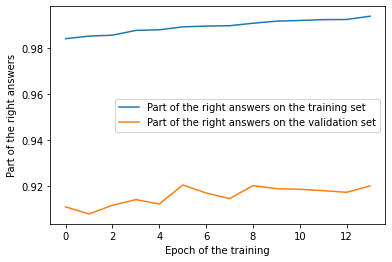

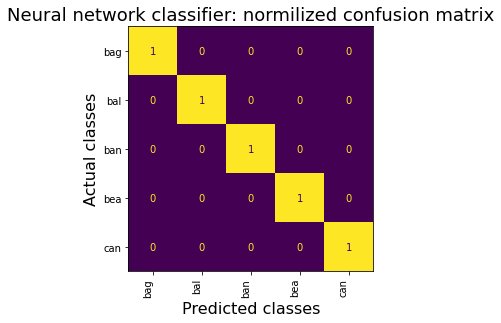

----------------------------------------------------------------------------------------------------
Neural network: classifier
Class: bag                  100% neural network predicted as a class bag                  - Correct
Class: bal                  100% neural network predicted as a class bal                  - Correct
Class: ban                  100% neural network predicted as a class ban                  - Correct
Class: bea                  100% neural network predicted as a class bea                  - Correct
Class: can                  100% neural network predicted as a class can                  - Correct


IndexError: ignored

In [ ]:
# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
EPOCHS        = 100                       # Epochs

# Training of the model
train_model(model, 
            train_generator, 
            validation_generator, 
            test_generator, 
            class_labels=CLASS_LIST, 
            title='classifier'
            )


In [ ]:
# Fine tuning
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 800)               20071200  
                                                                 
 dense_1 (Dense)             (None, 400)               320400    
                                                                 
 dense_2 (Dense)             (None, 10)                4010      
                                                                 
Total params: 35,110,298
Trainable params: 27,475,034
Non-trainable params: 7,635,264
_________________________________________________________________


Epoch 1/100
216/216 [==============================] - 431s 2s/step - loss: 0.0421 - accuracy: 0.9934 - val_loss: 0.2302 - val_accuracy: 0.9271 - lr: 1.0000e-06
Epoch 2/100
216/216 [==============================] - 419s 2s/step - loss: 0.0247 - accuracy: 0.9954 - val_loss: 0.2395 - val_accuracy: 0.9220 - lr: 1.0000e-06
Epoch 3/100
216/216 [==============================] - 423s 2s/step - loss: 0.0185 - accuracy: 0.9964 - val_loss: 0.1985 - val_accuracy: 0.9300 - lr: 1.0000e-06
Epoch 4/100
216/216 [==============================] - 417s 2s/step - loss: 0.0136 - accuracy: 0.9979 - val_loss: 0.2395 - val_accuracy: 0.9229 - lr: 1.0000e-06
Epoch 5/100
216/216 [==============================] - 415s 2s/step - loss: 0.0106 - accuracy: 0.9986 - val_loss: 0.2049 - val_accuracy: 0.9275 - lr: 1.0000e-06
Epoch 6/100
216/216 [==============================] - 420s 2s/step - loss: 0.0092 - accuracy: 0.9986 - val_loss: 0.1955 - val_accuracy: 0.9314 - lr: 1.0000e-06
Epoch 7/100
216/216 [=============

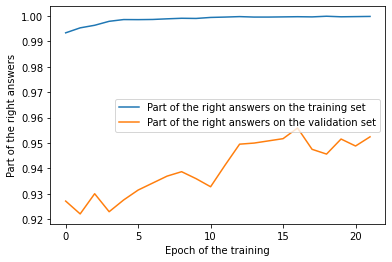

In [ ]:
# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
EPOCHS        = 100                       # Epochs

# Training of the model
train_model(model, 
            train_generator, 
            validation_generator, 
            test_generator, 
            class_labels=CLASS_LIST, 
            title='classifier'
            )

In [ ]:
# Final accuracy for test data
# scores[0] - loss
# scores[1] - percents of correct answers

scores = model.evaluate(test_generator, verbose=0)  
print('\nPercent of the right answers on the test data: {:.2%}\n'\
      .format(scores[1]))

UnknownError: ignored